In [90]:
import json 
def read_json(file = "parametros_gpt.json"):
    with open(file, 'r') as f:
        data = json.load(f)
        return data
dic = read_json()
dic.keys()
print(dic["first_residual"])

{'in_channels': 1, 'out_channels': 8, 'kernel_size': 1, 'padding': 0, 'dilation': 1}


In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self, parametros:dict):
        super(UNet, self).__init__()

        #FIRST
        self.first_residual = nn.Sequential(
            # 1x1 Conv, 8
            nn.Conv2d(**parametros["first_residual"]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["first_residual"]["out_channels"]) #OUTCHANNELS
        )

        self.first_conv = nn.Sequential(
            nn.Conv2d(**parametros["first_conv"][0]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["first_conv"][0]["out_channels"]),
            nn.Conv2d(**parametros["first_conv"][1]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["first_conv"][1]["out_channels"])
        )

        # DOWN PATH
        ##
        ## BLOCK1
        self.down_pooling1 = nn.MaxPool2d(**parametros["down_pooling1"])

        self.block1_residual = nn.Sequential(
            nn.Conv2d(**parametros["block1_residual"]),
            nn.BatchNorm2d(parametros["block1_residual"]["out_channels"])
        )
        self.block1_conv = nn.Sequential(
            nn.Conv2d(**parametros["block1_conv"][0]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["block1_conv"][0]["out_channels"]),
            nn.Conv2d(**parametros["block1_conv"][1]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["block1_conv"][1]["out_channels"])
        )

        ## BLOCK2
        self.down_pooling2 = nn.MaxPool2d(**parametros["down_pooling2"])

        self.block2_residual = nn.Sequential(
            nn.Conv2d(**parametros["block2_residual"]),
            nn.BatchNorm2d(parametros["block2_residual"]["out_channels"])
        )
        self.block2_conv = nn.Sequential(
            nn.Conv2d(**parametros["block2_conv"][0]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["block2_conv"][0]["out_channels"]),
            nn.Conv2d(**parametros["block2_conv"][1]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["block2_conv"][1]["out_channels"])
        )


        # UP PATH
        ##
        ## BLOCK 1
        self.up_layer1 = nn.ConvTranspose2d(**parametros["up_layer1"])
        
        parametros["conv_bridge1"]["padding"] = (parametros["conv_bridge1"]["kernel_size"]-1)//2
        self.conv_bridge1 = nn.Conv2d(**parametros["conv_bridge1"])
        
        self.up_block1_residual = nn.Sequential(
            nn.Conv2d(**parametros["up_block1_residual"]),
            nn.BatchNorm2d(parametros["up_block1_residual"]["out_channels"])
        )
        self.up_block1_conv = nn.Sequential(
            nn.Conv2d(**parametros["up_block1_conv"][0]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["up_block1_conv"][0]["out_channels"]),
            nn.Conv2d(**parametros["up_block1_conv"][1]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["up_block1_conv"][1]["out_channels"])
        )

        ## BLOCK 2
        self.up_layer2 = nn.ConvTranspose2d(**parametros["up_layer2"])
        
        parametros["conv_bridge2"]["padding"] = (parametros["conv_bridge2"]["kernel_size"]-1)//2
        self.conv_bridge2 = nn.Conv2d(**parametros["conv_bridge2"])
        
        self.up_block2_residual = nn.Sequential(
            nn.Conv2d(**parametros["up_block2_residual"]),
            nn.BatchNorm2d(parametros["up_block2_residual"]["out_channels"])
        )
        self.up_block2_conv = nn.Sequential(
            nn.Conv2d(**parametros["up_block2_conv"][0]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["up_block2_conv"][0]["out_channels"]),
            nn.Conv2d(**parametros["up_block2_conv"][1]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["up_block2_conv"][1]["out_channels"])
        )



        # FINAL
        self.conv_final = nn.Conv2d(**parametros["conv_final"])


    def forward(self, x):
        # FIRST
        first_residual = self.first_residual(x)
        first_conv = self.first_conv(x)

        out_first = first_conv+first_residual
        # --------------------------------------------
        # BLOCK 1
        outpooling1 = self.down_pooling1(out_first)

        block1_residual = self.block1_residual(outpooling1)
        block1_conv = self.block1_conv(outpooling1)

        out_block1 = block1_conv+block1_residual
        # --------------------------------------------
        # BLOCK 2
        outpooling2 = self.down_pooling2(out_block1)# mudar pra um downpooling2

        block2_residual = self.block2_residual(outpooling2)
        block2_conv = self.block2_conv(outpooling2)

        out_block2 = block2_conv+block2_residual

        # --------------------------------------------
        # UP BLOCK 1
        out_uplayer1 = self.up_layer1(out_block2)
        out_convBridge1 = self.conv_bridge1(out_block1)
        out_Concat1 = torch.cat([out_uplayer1, out_convBridge1], dim=1)

        up_block1_residual = self.up_block1_residual(out_Concat1)
        up_block1_conv = self.up_block1_conv(out_Concat1)
        out_up_block1 = up_block1_conv+up_block1_residual

        # --------------------------------------------
        # UP BLOCK 2
        out_uplayer2 = self.up_layer2(out_up_block1)
        out_convBridge2 = self.conv_bridge2(out_first)
        out_Concat2 = torch.cat([out_uplayer2, out_convBridge2], dim=1)

        up_block2_residual = self.up_block2_residual(out_Concat2)
        up_block2_conv = self.up_block2_conv(out_Concat2)
        out_up_block2 = up_block2_conv+up_block2_residual

        final = self.conv_final(out_up_block2)
        
        return final

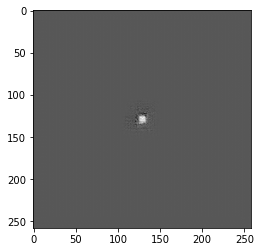

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.manual_seed(5)

# Inicializando o modelo e passando o tensor de entrada
input_tensor = torch.zeros(1, 1, 256, 256)
input_tensor[0,0,124:132,124:132] = 255
model = UNet(dic)
output = model(input_tensor)
output = output[0,:,:,:]

img = output.detach().numpy()
plt.imshow(img[1,:,:], cmap = "gray")

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self, parametros):
        super(UNet, self).__init__()

        # FIRST
        self.first_residual = nn.Sequential(
            nn.Conv2d(**parametros["first_residual"]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["first_residual"]["out_channels"])
        )

        self.first_conv = nn.Sequential(
            nn.Conv2d(**parametros["first_conv"][0]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["first_conv"][0]["out_channels"]),
            nn.Conv2d(**parametros["first_conv"][1]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["first_conv"][1]["out_channels"])
        )

        # DOWN PATH
        self.down_pooling1 = nn.MaxPool2d(**parametros["down_pooling1"])

        self.block1_residual = nn.Sequential(
            nn.Conv2d(**parametros["block1_residual"]),
            nn.BatchNorm2d(parametros["block1_residual"]["out_channels"])
        )
        self.block1_conv = nn.Sequential(
            nn.Conv2d(**parametros["block1_conv"][0]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["block1_conv"][0]["out_channels"]),
            nn.Conv2d(**parametros["block1_conv"][1]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["block1_conv"][1]["out_channels"])
        )

        self.down_pooling2 = nn.MaxPool2d(**parametros["down_pooling2"])

        self.block2_residual = nn.Sequential(
            nn.Conv2d(**parametros["block2_residual"]),
            nn.BatchNorm2d(parametros["block2_residual"]["out_channels"])
        )
        self.block2_conv = nn.Sequential(
            nn.Conv2d(**parametros["block2_conv"][0]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["block2_conv"][0]["out_channels"]),
            nn.Conv2d(**parametros["block2_conv"][1]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["block2_conv"][1]["out_channels"])
        )

        # UP PATH
        self.up_layer1 = nn.ConvTranspose2d(**parametros["up_layer1"])
        self.conv_bridge1 = nn.Conv2d(**parametros["conv_bridge1"])
        self.up_block1_residual = nn.Sequential(
            nn.Conv2d(**parametros["up_block1_residual"]),
            nn.BatchNorm2d(parametros["up_block1_residual"]["out_channels"])
        )
        self.up_block1_conv = nn.Sequential(
            nn.Conv2d(**parametros["up_block1_conv"][0]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["up_block1_conv"][0]["out_channels"]),
            nn.Conv2d(**parametros["up_block1_conv"][1]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["up_block1_conv"][1]["out_channels"])
        )

        self.up_layer2 = nn.ConvTranspose2d(**parametros["up_layer2"])
        self.conv_bridge2 = nn.Conv2d(**parametros["conv_bridge2"])
        self.up_block2_residual = nn.Sequential(
            nn.Conv2d(**parametros["up_block2_residual"]),
            nn.BatchNorm2d(parametros["up_block2_residual"]["out_channels"])
        )
        self.up_block2_conv = nn.Sequential(
            nn.Conv2d(**parametros["up_block2_conv"][0]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["up_block2_conv"][0]["out_channels"]),
            nn.Conv2d(**parametros["up_block2_conv"][1]),
            nn.ReLU(),
            nn.BatchNorm2d(parametros["up_block2_conv"][1]["out_channels"])
        )

        self.conv_final = nn.Conv2d(**parametros["conv_final"])

    def forward(self, x):
        # FIRST
        first_residual = self.first_residual(x)
        first_conv = self.first_conv(x)
        out_first = first_conv + first_residual

        # BLOCK 1
        outpooling1 = self.down_pooling1(out_first)
        block1_residual = self.block1_residual(outpooling1)
        block1_conv = self.block1_conv(outpooling1)
        out_block1 = block1_conv + block1_residual

        # BLOCK 2
        outpooling2 = self.down_pooling2(out_block1)
        block2_residual = self.block2_residual(outpooling2)
        block2_conv = self.block2_conv(outpooling2)
        out_block2 = block2_conv + block2_residual

        # UP BLOCK 1
        out_uplayer1 = self.up_layer1(out_block2)
        out_convBridge1 = self.conv_bridge1(out_block1)
        out_Concat1 = torch.cat([out_uplayer1, out_convBridge1], dim=1)
        up_block1_residual = self.up_block1_residual(out_Concat1)
        up_block1_conv = self.up_block1_conv(out_Concat1)
        out_up_block1 = up_block1_conv + up_block1_residual

        # UP BLOCK 2
        out_uplayer2 = self.up_layer2(out_up_block1)
        out_convBridge2 = self.conv_bridge2(out_first)
        out_Concat2 = torch.cat([out_uplayer2, out_convBridge2], dim=1)
        up_block2_residual = self.up_block2_residual(out_Concat2)
        up_block2_conv = self.up_block2_conv(out_Concat2)
        out_up_block2 = up_block2_conv + up_block2_residual

        final = self.conv_final(out_up_block2)
        return final
